In [3]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
from datetime import date
import jalali_pandas
import itertools
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from openpyxl import load_workbook
## Read DataFrame from excel file
df= pd.read_excel('E:\TOP\States\Volume\IR.xlsx', sheet_name="POS_Volume")
## Change DataType of date to Datetime
DATE = []
for y, m in zip(df.year, df.month):
    DATE.append(date(y, m, 1))
df['date'] = DATE
df['date'] = df['date'].astype(str)
type(df.loc[0,'date'])
df['date'] = df['date'].jalali.parse_jalali("%Y-%m-%d").jalali.to_gregorian()
## Make a New DataFrame based on the column that you want to Predict
Data=pd.DataFrame({'Date':df['date'],'Pos_Volume':df["POS_Volume"]})
# Data=Data.iloc[90:,:] #if you want to truncate your data use this line

In [ ]:
### Scaling data
# import numpy as np
# from sklearn.preprocessing import StandardScaler
# scaler=StandardScaler()
# scaled_data=scaler.fit_transform(np.array(Data['Pos_Value']).reshape(-1,1))
# scaled_data=pd.Series(scaled_data.flatten())
# # scaled_data
# from statsmodels.tsa.stattools import adfuller
# d=0
# data1=scaled_data
# adf_result=adfuller(data1)
# while adf_result[1] > 0.05:
#     d += 1
#     data1=data1.diff().dropna()
#     adf_result=adfuller(data1)
# # print(f"ADF result is {adf_result} for d order equls {d}")

In [4]:
# Estimating p, d, q order of ARIMA model
from statsmodels.tsa.stattools import adfuller
data1=Data['Pos_Volume']
adf_result=adfuller(data1)
d=0
while adf_result[1] > 0.05:
    d += 1
    data1=data1.diff().dropna()
    adf_result=adfuller(data1)
# print(f"ADF result is {adf_result} for d order equls {d}")
# Estimating p  and q, orders of ARIMA model 
q_optimize, p_optimize= 0,0
current_aic=10000
for i in range(1,15):
    for j in range(1,15):
        p , q =i , j
        warnings.filterwarnings("ignore")
        model = ARIMA(Data['Pos_Volume'].dropna(), order=(p, d, q))
        model.initialize_approximate_diffuse()
        result = model.fit()
        if result.aic.astype(int) < current_aic:
            current_aic=result.aic.astype(int)
            q_optimize=j
            p_optimize=i
model = ARIMA(Data['Pos_Volume'].dropna(), order=(p_optimize, d, q_optimize))
result = model.fit()
# result.summary()


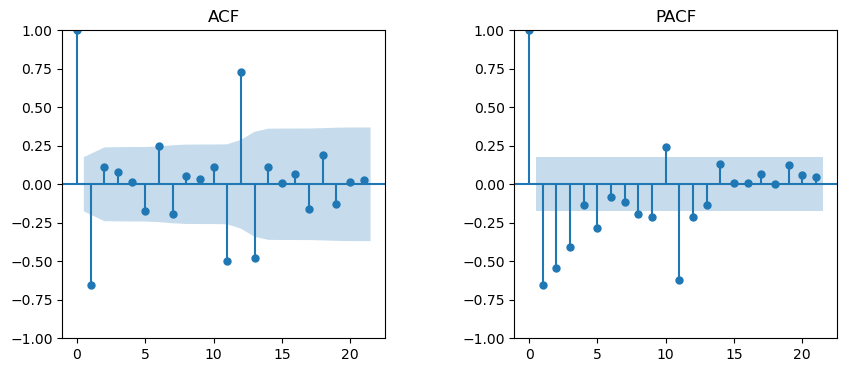

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes=plt.subplots(nrows=1, ncols=2, figsize=(10,4))
plot_acf(data1, axes[0])
axes[0].set_title('ACF')
plot_pacf(data1, axes[1])
axes[1].set_title('PACF')
plt.subplots_adjust(wspace=0.4)
plt.show()

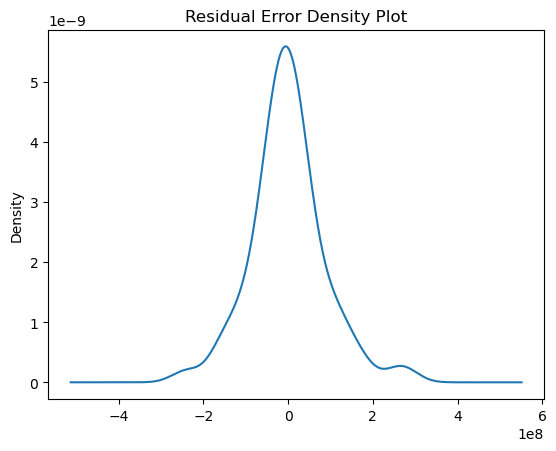

count    1.260000e+02
mean    -8.122871e+04
std      8.677846e+07
min     -2.469905e+08
25%     -4.494138e+07
50%     -3.512382e+06
75%      3.730172e+07
max      2.848883e+08
dtype: float64


In [15]:
import matplotlib.pyplot as plt
result.resid.plot(kind='kde')
plt.title('Residual Error Density Plot')
plt.show()
# summary stats of residuals
print(result.resid.describe())

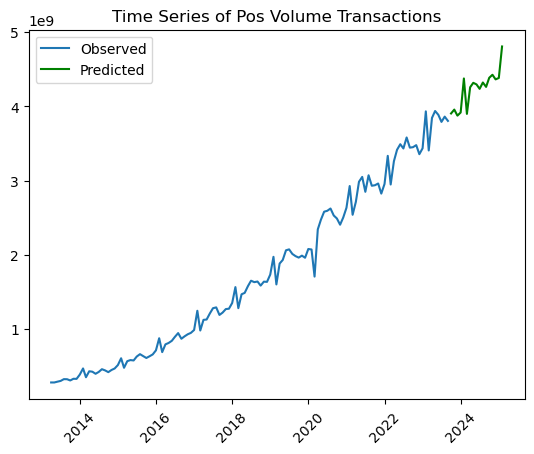

In [16]:
forecast_steps = 17
# Alpha=[0.1,0.05,0.03]
Alpha=[0.05]
forecast_values=pd.DataFrame()
Forecast=pd.DataFrame()
for i in Alpha:
    forecast=result.get_forecast(steps=forecast_steps, alpha= i)
    forecast_values[i]=pd.DataFrame(forecast.predicted_mean)
    ConfidenceInterval=pd.DataFrame(forecast.conf_int())
    Forecast[f'Alpha: {i}']=pd.DataFrame(forecast_values[i])
    Forecast[f'Lower_{i}']=pd.DataFrame({f'Lower_{i}': ConfidenceInterval['lower Pos_Volume']})
    Forecast[f'Upper_{i}']=pd.DataFrame({f'Upper_{i}': ConfidenceInterval['upper Pos_Volume']})

from datetime import datetime, timedelta
start_date = datetime.strptime(Data['Date'].iloc[0].strftime('%Y-%m-%d') ,'%Y-%m-%d')-timedelta(days=30)
num_month = len(Data['Date'])+forecast_steps
date_range = pd.date_range(start=start_date,periods=num_month, freq='MS').strftime('%Y-%m-%d')
date_range =pd.to_datetime(date_range, format='%Y-%m-%d')
date = pd.DataFrame({'date': date_range})
date1=date.iloc[:len(Data['Date']),:]
date2=date.iloc[len(Data['Date']):,:]
# Data_predict=pd.DataFrame()
# Data_predict['date']=date_ranged
# Data_predict['observed']=Data['Volume_POS']


plt.plot(date1, Data['Pos_Volume'],label='Observed')
plt.plot(date2,Forecast['Alpha: 0.05'], color='green', label='Predicted')
plt.title('Time Series of Pos Volume Transactions')
plt.legend()
plt.xticks(rotation=45)
plt.show()
